# How good are the embeddings?

1. Drug Classification

- Various prompting methods - "This drug is used to treat", "this drug is classified as", "this drug is used for", "
- `drugbank` dataset
- Compare to BioGPT, BioBERT
- Baseline?

2. Link Prediction

- related drugs. Related based on what?


3. Regression task?

## See accuracies for each model below

In [19]:
import pandas as pd
import numpy as np
from utils import drug_data_tools

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [2]:
drug_classes = pd.read_csv("outputs/drug-classes.csv", index_col=0)#, index_col="Drug Name")
drug_classes

,Drug Class
Drug Name,
ella,Progesterone receptor modulators
pancreatin,Digestive enzymes
boroleum,Topical rubefacient
benicar,Angiotensin receptor blockers
duac,Topical acne agents
...,...
acne-10-gel-topical,Topical acne agents
lorbrena,Multikinase inhibitors
halcion,Benzodiazepines


In [3]:
selected_molecules = drug_data_tools.get_selected_molecules(filter_molecules=False)
len(selected_molecules)

5747

In [4]:
# Drugs that are both in Drugs.com (i.e. we have class information for) and Selected Molecules
len(set(drug_classes.index).intersection(selected_molecules))

629

In [5]:
# Select them out
selected_drugs_com_molecules = drug_classes[drug_classes.index.isin(set(drug_classes.index).intersection(selected_molecules))]
# intersecting_drugs

In [6]:
selected_drugs_com_molecules['Drug Class'].value_counts()

Drug Class
Multikinase inhibitors                      23
Nonsteroidal anti-inflammatory drugs        11
Angiotensin Converting Enzyme Inhibitors    11
Miscellaneous antineoplastics               11
Opioids (narcotic analgesics)               11
                                            ..
Estrogens                                    1
Methylxanthines                              1
Sterile irrigating solutions                 1
Diarylquinolines                             1
First generation cephalosporins              1
Name: count, Length: 220, dtype: int64

Filter out classes with less than 3 drugs in them

In [7]:
class_counts = selected_drugs_com_molecules["Drug Class"].value_counts()
selected_drugs_com_molecules = selected_drugs_com_molecules[~selected_drugs_com_molecules['Drug Class'].isin(class_counts[class_counts < 3].index)]

selected_drugs_com_molecules

,Drug Class
Drug Name,
paliperidone,Atypical antipsychotics
carboplatin,Alkylating agents
apraclonidine,Ophthalmic glaucoma agents
naproxen,Nonsteroidal anti-inflammatory drugs
fesoterodine,Urinary antispasmodics
...,...
ixazomib,Proteasome inhibitors
terbinafine,Miscellaneous antifungals
azithromycin,Macrolides


In [8]:
# Nr unique drug classes after filtering
len(set(selected_drugs_com_molecules['Drug Class']))

89

Load Llama embeddings of Selected Molecules. select out only intersecting ones

In [9]:
# You may need to unzip this file
df_embeddings = pd.read_csv("outputs/llama-embeddings.csv", index_col=0)

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_2395/2717904247.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_embeddings = pd.read_csv("outputs/llama-embeddings.csv", index_col=0)


In [10]:
# TODO Why are some drugs missing? 115 vs 103
intersecting_drugs_w_embd_df = df_embeddings.loc[df_embeddings.index.intersection(set(selected_drugs_com_molecules.index))]
intersecting_drugs_w_embd_df.shape

(910, 4096)

Apply dimensionality reduction to embeddings to plot them

In [11]:
data = intersecting_drugs_w_embd_df
data['Drug Class'] = selected_drugs_com_molecules.loc[intersecting_drugs_w_embd_df.index]['Drug Class']
data.drop_duplicates(inplace=True)
data.shape

(460, 4097)

In [17]:
def add_class_and_names(dim_red_numpy_arr):
    """
        Sklearn's dimensionality reduction methods return numpy arrays. Add the drug class and drug name to the numpy array.
    """
    dim_red_numpy_arr = pd.DataFrame(dim_red_numpy_arr, index=intersecting_drugs_w_embd_df.index)
    dim_red_numpy_arr = pd.concat([pd.DataFrame(dim_red_numpy_arr, index=intersecting_drugs_w_embd_df.index), selected_drugs_com_molecules.loc[intersecting_drugs_w_embd_df.index]['Drug Class']], axis=1)

    dim_red_numpy_arr['Drug Class'] = pd.Series(dim_red_numpy_arr['Drug Class'], dtype="category")

    return dim_red_numpy_arr

# Run everything above up to this cell to load the data

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

t_sneezed_data = tsne.fit_transform(data.drop("Drug Class", axis=1))

print(type(t_sneezed_data))
print(t_sneezed_data.shape)

<class 'numpy.ndarray'>
(460, 2)


In [17]:
t_sneezed_data_classes = add_class_and_names(t_sneezed_data)
t_sneezed_data_classes.head()

,0,1,Drug Class
Drug Name,,,
metoprolol,-5.818011,13.180259,Cardioselective beta blockers
azithromycin,-8.057999,0.423768,Macrolides
rizatriptan,-5.772995,0.089574,Antimigraine agents
simvastatin,-9.969069,-6.373595,Statins
carvedilol,-12.766142,14.050718,Non-cardioselective beta blockers


In [18]:
t_sneezed_data_classes.dtypes

0              float32
1              float32
Drug Class    category
dtype: object

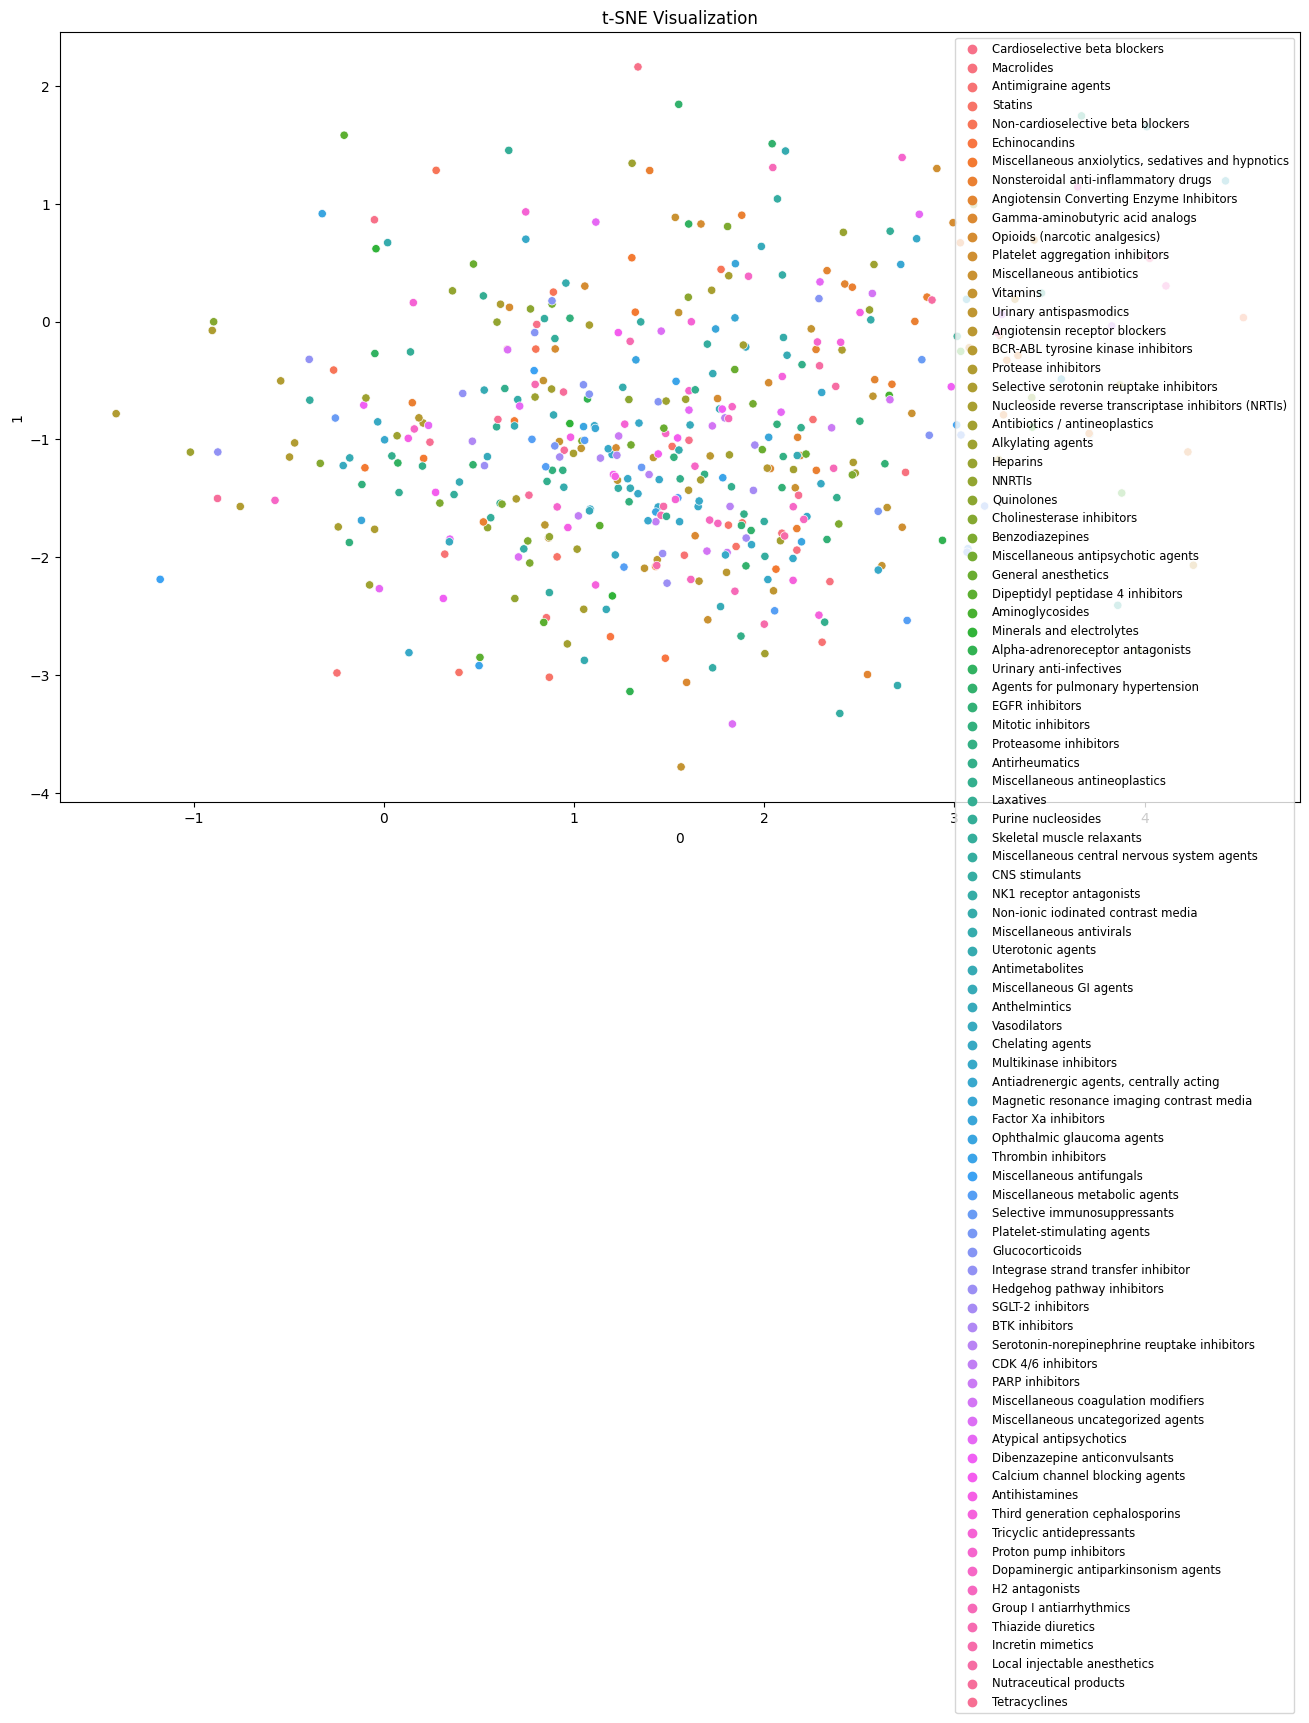

In [24]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=data.reset_index(drop=True), x='0', y='1', hue='Drug Class')


plt.title('t-SNE Visualization')
plt.legend(fontsize='small')
plt.show()

## Let's try 3D

In [25]:
tsne = TSNE(n_components=3, random_state=0)

t_sneezed_data = tsne.fit_transform(data.drop("Drug Class", axis=1))

print(type(t_sneezed_data))
print(t_sneezed_data.shape)

<class 'numpy.ndarray'>
(460, 3)


In [26]:
t_sneezed_data_classes = add_class_and_names(t_sneezed_data)

In [27]:
#change to widget for interactive
%matplotlib inline

In [28]:
def plot_interactive_3d(df_orig):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    df = df_orig.copy()

    cmap = plt.get_cmap("viridis")
    colors = cmap(np.linspace(0, 1, len(df["Drug Class"].cat.categories)))

    color_dict = dict(zip(df["Drug Class"].cat.categories, colors))

    df["Color"] = df["Drug Class"].cat.codes
    cmap = plt.cm.get_cmap("plasma", len(df["Drug Class"].cat.categories))

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Plot a 3D scatter plot
    sc = ax.scatter(df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], c=df["Color"], cmap=cmap)


    plt.show()

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_8720/3050845372.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("plasma", len(df["Drug Class"].cat.categories))


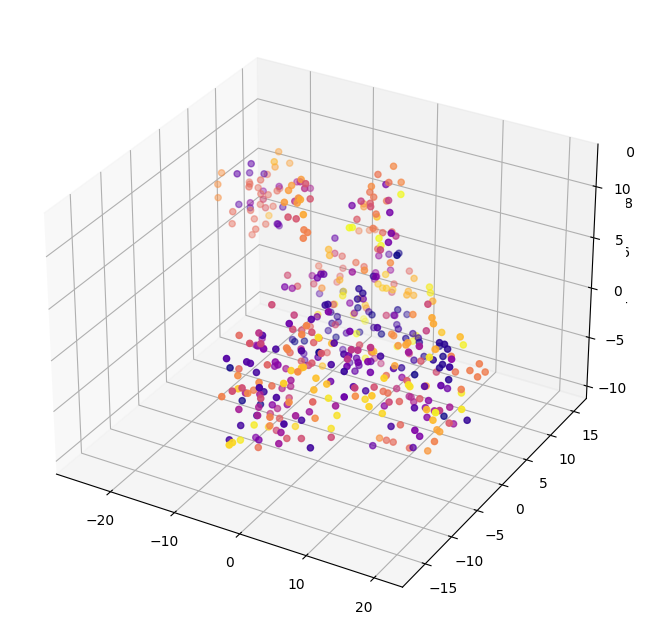

In [29]:
plot_interactive_3d(t_sneezed_data_classes)

## Let's perform Linear Discriminant Analysis to reduce the dimensionality of the embeddings, with the aim of classifying the drugs

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [32]:
lda = LDA(n_components=3)

lda_3d = lda.fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])
lda_3d.shape

(460, 3)

In [33]:
lda_3d = add_class_and_names(lda_3d)

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_8720/3050845372.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("plasma", len(df["Drug Class"].cat.categories))


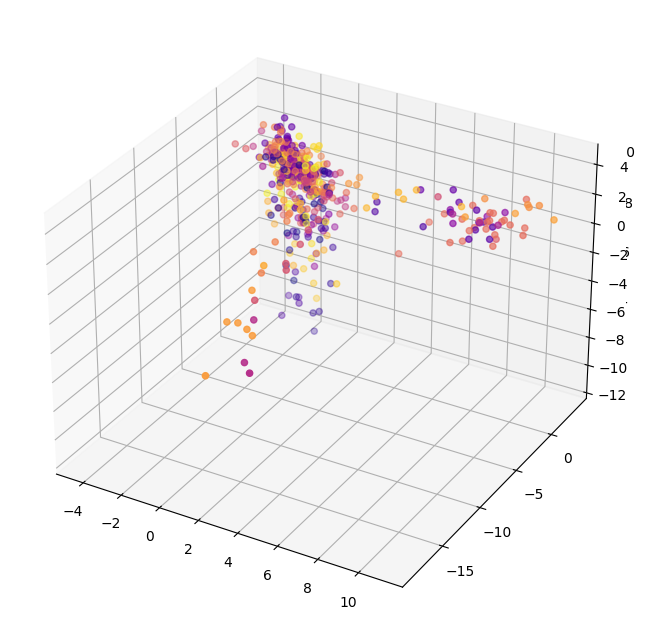

In [34]:
plot_interactive_3d(lda_3d)

## Let's classify using various methods to see performance

In [37]:
%matplotlib inline

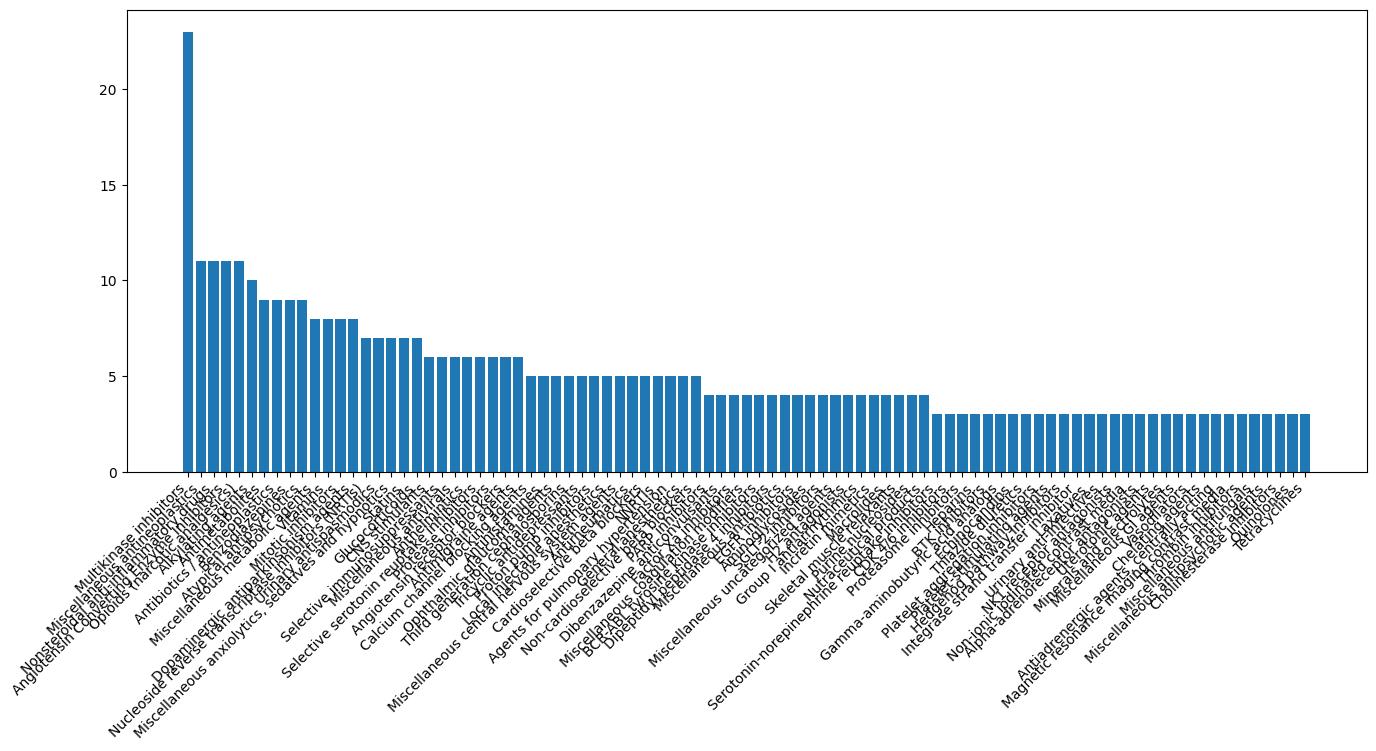

In [54]:
# Histogram of classes
plt.figure(figsize=(16, 6))

class_counts = data["Drug Class"].value_counts()
plt.bar(class_counts.index, class_counts.values)

# Rotate x-axis labels diagonally
plt.xticks(rotation=45, ha='right')

plt.show()


In [22]:
k = 5  # Number of folds

# Stratified K-Fold by default
def run_cross_val(model, data):
    scores = cross_val_score(model, data.drop("Drug Class", axis=1), data['Drug Class'], cv=k)

    print("Cross-validation scores:", scores)

    mean_accuracy = np.mean(scores)
    print("Mean accuracy:", mean_accuracy)

<font color="orange">No projection + Logistic Regression</font>

<font color="red">TODO Careful - there's a big variance between the different folds</font>

In [40]:
run_cross_val(LogisticRegression(max_iter=1000), data)

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

Cross-validation scores: [0.55434783 0.5        0.55434783 0.35869565 0.32608696]
Mean accuracy: 0.45869565217391306


LDA - 3 components

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [42]:
a = LDA(n_components=3).fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])

run_cross_val(LDA(n_components=3), add_class_and_names(a))

Cross-validation scores: [0.27173913 0.20652174 0.30434783 0.25       0.23913043]
Mean accuracy: 0.2543478260869565


/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


LDA can not have more components than n_classes

In [43]:
a = LDA(n_components=15).fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])

run_cross_val(LDA(n_components=15), add_class_and_names(a))

Cross-validation scores: [0.76086957 0.61956522 0.63043478 0.63043478 0.56521739]
Mean accuracy: 0.641304347826087


/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


<font color="orange">Interesting, by default LDA chooses fewer components than above?</font>

In [23]:
a = LDA().fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])

run_cross_val(LDA(), add_class_and_names(a))

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.75       0.64130435 0.64130435 0.63043478 0.54347826]
Mean accuracy: 0.6413043478260869


### LDA then Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

run_cross_val(RandomForestClassifier(), data)

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.41304348 0.38043478 0.41304348 0.25       0.30434783]
Mean accuracy: 0.3521739130434783


In [36]:
new_data = LDA(n_components=15).fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])
new_data = add_class_and_names(new_data)

run_cross_val(RandomForestClassifier(), new_data)

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.68478261 0.56521739 0.59782609 0.58695652 0.54347826]
Mean accuracy: 0.5956521739130436


In [40]:
len(data['Drug Class'].unique())

89

<font color="blue">LDA improves performance</font>

In [43]:
LDA(n_components=89).fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])

ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

In [41]:
import warnings

# Disable UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

n_classes = len(data['Drug Class'].unique())

lda_accuracies = []

# LDA cannot have more components than n_classes
for n_comp in range(5, n_classes, 5):
    new_data = LDA(n_components=n_comp).fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])
    new_data = add_class_and_names(new_data)

    print("Using n_components =", n_comp)
    run_cross_val(RandomForestClassifier(), new_data)


print("Using n_components =", n_classes)
run_cross_val(RandomForestClassifier(), data)

Using n_components = 5
Cross-validation scores: [0.4673913  0.40217391 0.41304348 0.39130435 0.31521739]
Mean accuracy: 0.3978260869565218
Using n_components = 10
Cross-validation scores: [0.55434783 0.5        0.5        0.5326087  0.4673913 ]
Mean accuracy: 0.5108695652173914
Using n_components = 15
Cross-validation scores: [0.66304348 0.57608696 0.63043478 0.60869565 0.55434783]
Mean accuracy: 0.6065217391304347
Using n_components = 20
Cross-validation scores: [0.70652174 0.61956522 0.68478261 0.64130435 0.58695652]
Mean accuracy: 0.6478260869565218
Using n_components = 25
Cross-validation scores: [0.69565217 0.61956522 0.69565217 0.64130435 0.60869565]
Mean accuracy: 0.6521739130434783
Using n_components = 30
Cross-validation scores: [0.68478261 0.68478261 0.7173913  0.65217391 0.60869565]
Mean accuracy: 0.6695652173913043
Using n_components = 35
Cross-validation scores: [0.73913043 0.69565217 0.75       0.64130435 0.63043478]
Mean accuracy: 0.691304347826087
Using n_components = 4

In [42]:
import warnings


# Disable UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

n_classes = len(data['Drug Class'].unique())


for n_comp in range(5, 250, 5):
    new_data = PCA(n_components=n_comp).fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])
    new_data = add_class_and_names(new_data)

    print("Using n_components =", n_comp)
    run_cross_val(RandomForestClassifier(), new_data)

Using n_components = 5
Cross-validation scores: [0.15217391 0.19565217 0.19565217 0.10869565 0.13043478]
Mean accuracy: 0.1565217391304348
Using n_components = 10
Cross-validation scores: [0.23913043 0.23913043 0.30434783 0.17391304 0.2173913 ]
Mean accuracy: 0.2347826086956522
Using n_components = 15
Cross-validation scores: [0.22826087 0.2826087  0.36956522 0.17391304 0.20652174]
Mean accuracy: 0.25217391304347825
Using n_components = 20
Cross-validation scores: [0.25       0.29347826 0.40217391 0.25       0.26086957]
Mean accuracy: 0.29130434782608694
Using n_components = 25
Cross-validation scores: [0.30434783 0.35869565 0.35869565 0.22826087 0.30434783]
Mean accuracy: 0.3108695652173913
Using n_components = 30
Cross-validation scores: [0.30434783 0.35869565 0.39130435 0.22826087 0.27173913]
Mean accuracy: 0.3108695652173913
Using n_components = 35
Cross-validation scores: [0.34782609 0.32608696 0.43478261 0.26086957 0.2826087 ]
Mean accuracy: 0.33043478260869563
Using n_components

LDA used just as dimensionality reduction, then XGBoost

In [33]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder # Transform Drug Classes to numeric

xg_data = LDA(n_components=15).fit_transform(data.drop("Drug Class", axis=1), data['Drug Class'])
xg_data = add_class_and_names(xg_data)
xg_data['Drug Class'] = LabelEncoder().fit_transform(xg_data['Drug Class'])

run_cross_val(xgb.XGBClassifier(), xg_data)

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.56521739 0.54347826 0.56521739 0.5326087  0.44565217]
Mean accuracy: 0.5304347826086956


TSNE (3 components) + Logistic Regression

In [45]:
from sklearn.manifold import TSNE

In [46]:
tsne = TSNE(n_components=3, random_state=0)
t_sneezed_data = tsne.fit_transform(data.drop("Drug Class", axis=1))

run_cross_val(LogisticRegression(max_iter=15000), add_class_and_names(t_sneezed_data))

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.17391304 0.11956522 0.13043478 0.11956522 0.15217391]
Mean accuracy: 0.1391304347826087


<font color="orange">TSNE(n_components=3) seems horrible, try PCA</font>

In [47]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA(n_components=3)
pcad_data = pca.fit_transform(data.drop("Drug Class", axis=1))

run_cross_val(LogisticRegression(max_iter=15000), add_class_and_names(pcad_data))

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.16304348 0.14130435 0.10869565 0.14130435 0.13043478]
Mean accuracy: 0.13695652173913045


## XGBoost

In [58]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder # Transform Drug Classes to numeric

xg_data = data.copy()
xg_data['Drug Class'] = LabelEncoder().fit_transform(xg_data['Drug Class'])

run_cross_val(xgb.XGBClassifier(), xg_data)

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.33695652 0.30434783 0.32608696 0.19565217 0.25      ]
Mean accuracy: 0.28260869565217395


## SVM

In [61]:
from sklearn.svm import SVC

run_cross_val(SVC(), data)

/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.20652174 0.19565217 0.18478261 0.13043478 0.13043478]
Mean accuracy: 0.16956521739130434


### We don't know based on which metric the embeddings are created

Is it similarity in target disease? Molecule similarity? Use in same sentences etc

# Embed Drug Class names, see how close they are to the drugs themselves

In [13]:
data["Drug Class"].value_counts()

Drug Class
Multikinase inhibitors                      23
Miscellaneous antineoplastics               11
Nonsteroidal anti-inflammatory drugs        11
Angiotensin Converting Enzyme Inhibitors    11
Opioids (narcotic analgesics)               11
                                            ..
Miscellaneous antifungals                    3
Miscellaneous antipsychotic agents           3
Cholinesterase inhibitors                    3
Quinolones                                   3
Tetracyclines                                3
Name: count, Length: 89, dtype: int64

In [44]:
# Load Drug Class embeddings from CSV instead

from langchain.embeddings import LlamaCppEmbeddings
import numpy as np

llama = LlamaCppEmbeddings(model_path="models/ggml-model-q4_0.bin")

llama.cpp: loading model from models/ggml-model-q4_0.bin
llama.cpp: can't use mmap because tensors are not aligned; convert to new format to avoid this
llama_model_load_internal: format     = 'ggml' (old version with low tokenizer quality and no mmap support)
llama_model_load_internal: n_vocab    = 32000
llama_model_load_internal: n_ctx      = 512
llama_model_load_internal: n_embd     = 4096
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 32
llama_model_load_internal: n_layer    = 32
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 2 (mostly Q4_0)
llama_model_load_internal: n_ff       = 11008
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 7B
llama_model_load_internal: ggml ctx size = 4113748.20 KB
llama_model_load_internal: mem required  = 5809.33 MB (+ 2052.00 MB per state)
...................................................................................................
.
llama_

In [45]:
a = llama.embed_query("the drug class of aspirin is ")
np.array(a).shape


llama_print_timings:        load time =   485.38 ms
llama_print_timings:      sample time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings: prompt eval time =   591.48 ms /    10 tokens (   59.15 ms per token)
llama_print_timings:        eval time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings:       total time =   596.67 ms


(4096,)

In [15]:
# drug_class_embeddings = []

# for drug_class in data["Drug Class"].unique():
#     drug_class_embeddings.append(np.array(llama.embed_query(drug_class)))

# drug_class_embeddings = np.array(drug_class_embeddings)
# drug_class_embeddings = pd.DataFrame(drug_class_embeddings, index=data["Drug Class"].unique())
# drug_class_embeddings

In [16]:
# drug_class_embeddings.to_csv("outputs/drug-class-embeddings.csv", index=True)

In [17]:
drug_class_embeddings = pd.read_csv("outputs/drug-class-embeddings.csv", index_col=0)
drug_class_embeddings

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Cardioselective beta blockers,-2.024681,0.763601,0.271101,-6.677819,-2.043296,1.326308,1.419001,-0.027740,0.737718,1.068877,...,-0.597101,0.495246,-2.453109,0.287094,-2.404189,-1.674368,0.639390,-3.518879,-1.596792,1.875519
Macrolides,-2.473125,0.550319,-0.599043,-7.605944,-3.322309,0.912390,0.669073,0.735324,-0.084497,-0.101670,...,-1.130123,2.270396,-2.255825,0.104438,-0.974107,-1.417680,0.266473,-0.360478,-0.297196,2.554208
Antimigraine agents,-3.715678,0.849253,-0.472053,-6.340028,-3.455702,0.610372,1.890064,0.493247,-0.331297,0.620744,...,-0.630629,0.333034,-3.058589,-0.056093,-1.722746,-2.283842,-1.052267,-1.491576,0.583877,1.633311
Statins,-3.443108,0.854087,-1.260531,-5.241650,-0.762372,-0.389250,-0.671271,1.331643,0.708447,0.982971,...,-1.832110,1.050839,-1.566010,0.648366,0.109845,-1.720845,-1.299765,-3.589334,0.267854,1.237302
Non-cardioselective beta blockers,-3.002476,1.164129,0.009429,-5.019248,-1.493509,1.515889,0.893329,0.187844,-0.150657,2.362413,...,-0.598664,0.420552,-2.545812,0.588057,-1.638871,-1.818123,-0.169838,-3.149646,-1.769000,2.462077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thiazide diuretics,-0.741513,-0.599100,0.515994,-1.247712,-0.301162,1.413272,-1.431750,-0.870100,-0.332860,-1.620354,...,1.482342,0.369431,-1.681991,0.240945,-2.478794,-1.238343,1.383634,-1.624532,-0.264419,0.371440
Incretin mimetics,-1.853538,-0.622988,0.309266,-7.674756,-1.505980,-0.138055,1.544240,1.626740,-0.264407,0.236036,...,-1.332700,1.336669,-2.822367,-0.192845,-1.679615,-0.514796,-0.330601,-0.596610,-0.674692,1.311977
Local injectable anesthetics,-1.657471,1.910512,-0.144925,-2.449739,-1.374596,0.699252,0.063688,1.076674,-1.159147,0.120393,...,-0.124153,0.205888,-1.301211,-0.457076,1.823892,-1.235777,0.807780,-0.386043,-0.182684,2.546897
Nutraceutical products,-3.681692,-0.169289,1.139045,-4.735497,-1.012755,-0.679919,0.556858,-0.813668,-2.540787,-0.962098,...,-0.086119,-0.202184,-1.781946,-0.472769,-0.393596,0.107214,1.639714,0.460966,-1.123219,0.847961


Let's compute dot product between all drugs of a certain class, and that class's embedding

In [18]:
opioid_class_embd = drug_class_embeddings.loc[drug_class_embeddings.index == 'Opioids (narcotic analgesics)']
opioid_class_embd

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Opioids (narcotic analgesics),-3.741259,-0.297616,1.425392,-5.429101,-3.261732,-0.520125,0.309451,1.385917,-0.320755,2.388529,...,-0.516436,-0.34766,-2.530288,0.534414,-0.551123,-1.198511,0.17607,-1.241283,1.09682,1.29681


In [19]:
# Select drugs where drug class = 'Opioids (narcotic analgesics)'
opioids_embd = data[data["Drug Class"] == 'Opioids (narcotic analgesics)']
opioids_embd.drop("Drug Class", axis=1, inplace=True)

opioids_embd#.head()

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_9908/1050802030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opioids_embd.drop("Drug Class", axis=1, inplace=True)


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Drug Name,,,,,,,,,,,,,,,,,,,,,
tramadol,3.237586,-0.116447,0.582508,-3.759468,-1.252657,1.904890,1.303443,-2.323098,-0.888051,0.800700,...,0.421497,-0.461952,1.208384,0.152175,-0.626893,-0.621981,1.668541,-1.291799,-0.098456,2.668765
fentanyl,2.190223,-1.137000,-1.297709,-5.094807,0.208010,1.718343,-0.910200,-0.215022,-0.432251,0.826980,...,-1.419770,2.060445,1.720899,-0.452931,-0.297092,-1.475184,-0.183682,-0.925645,0.379095,-0.384817
tapentadol,0.660039,0.120690,0.847331,-2.521814,-2.188934,0.262902,0.084353,-2.169062,-1.227686,-0.649225,...,1.100362,1.643811,1.768036,1.121249,-1.848173,0.615526,0.068010,-0.700147,-1.819949,0.105395
sufentanil,2.992477,0.839126,0.198039,-6.951650,-1.558402,0.582205,0.083071,0.258074,-0.868335,1.408915,...,-0.123788,0.437499,-0.147526,-0.860904,-1.595355,-1.252347,0.565401,-2.243841,0.536886,2.296238
alfentanil,3.077238,-0.221803,-0.423923,-3.141700,1.100122,0.767756,0.427606,0.063163,-0.848364,0.192691,...,-0.813523,0.327543,0.331809,-1.521257,-2.771806,0.624124,-1.623885,-1.510071,-0.005713,1.811100
remifentanil,1.667061,0.828027,-0.359928,-4.466528,-1.022010,0.556421,-0.893475,-0.478869,-1.517688,0.727250,...,1.005439,0.465192,-0.373026,-0.925081,-1.234975,-1.171545,0.946949,-1.360911,0.390724,1.573607
oxycodone,0.900632,-0.232560,0.107981,-1.182961,1.051073,2.157259,-0.634117,-0.087659,-0.812542,1.031293,...,-0.035459,0.569642,-0.236300,1.456721,-2.380483,-2.538499,1.766062,-0.613267,0.252096,1.840955
hydromorphone,2.022954,-0.519373,0.180329,-2.041638,-0.293389,2.522967,-1.600348,1.055727,-1.158654,-0.584333,...,0.219213,1.611140,-0.332483,0.213398,1.005168,-1.375098,-0.033981,0.096304,0.484449,0.049904
buprenorphine,1.754361,-0.653762,0.669841,-4.615219,1.231773,2.093247,-0.958788,-1.494837,-1.036810,-0.786234,...,-1.505358,2.251798,-0.987756,1.597452,-0.421418,-0.119986,0.449953,-0.261026,-0.597953,0.576231


In [20]:
# Need to convert to numpy array. Does not work with pandas
np.array(opioid_class_embd) @ np.array(opioids_embd).T

array([[2516.28896569, 1219.50502554,  271.67643734, 3403.89667256,
         866.36644065, 3127.0505293 , 2658.48642153, 2349.58464152,
        1598.37197391, 4241.48283719,  630.51397434]])

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
(np.array(drug_class_embeddings) @ np.array(data.drop("Drug Class", axis=1)).T).shape

(89, 460)

In [23]:
a = cosine_similarity(np.array(drug_class_embeddings), np.array(data.drop("Drug Class", axis=1)))
print(a)
print(a.shape)


[[ 0.3105175   0.2255842   0.19540668 ...  0.16089779  0.08347237
   0.41893739]
 [ 0.25285608  0.13913042  0.14337363 ...  0.07965223  0.01852606
   0.43750828]
 [ 0.10965883 -0.02777886  0.01201596 ... -0.07590326 -0.0982493
   0.35512311]
 ...
 [ 0.11283456  0.01274886  0.02146264 ... -0.02561118 -0.05808539
   0.31565697]
 [ 0.37990073  0.39031669  0.31585944 ...  0.33796342  0.26182768
   0.34489571]
 [ 0.58700665  0.74068419  0.58440193 ...  0.70336517  0.59990697
   0.2694032 ]]
(89, 460)


In [24]:
cosine_df = pd.DataFrame(a.T, index=data.index, columns=data["Drug Class"].unique())
# cosine_df["True Drug Class"] = data["Drug Class"]
cosine_df.insert(0, 'True Drug Class', data["Drug Class"])
cosine_df

,True Drug Class,Cardioselective beta blockers,Macrolides,Antimigraine agents,Statins,Non-cardioselective beta blockers,Echinocandins,"Miscellaneous anxiolytics, sedatives and hypnotics",Nonsteroidal anti-inflammatory drugs,Angiotensin Converting Enzyme Inhibitors,...,Tricyclic antidepressants,Proton pump inhibitors,Dopaminergic antiparkinsonism agents,H2 antagonists,Group I antiarrhythmics,Thiazide diuretics,Incretin mimetics,Local injectable anesthetics,Nutraceutical products,Tetracyclines
Drug Name,,,,,,,,,,,,,,,,,,,,,
metoprolol,Cardioselective beta blockers,0.310517,0.252856,0.109659,0.312224,0.301316,0.534238,0.544589,-0.010577,0.412114,...,0.165919,0.582897,0.288236,0.301384,0.174363,0.590024,0.419226,0.112835,0.379901,0.587007
azithromycin,Macrolides,0.225584,0.139130,-0.027779,0.222525,0.215832,0.660735,0.610466,-0.180701,0.372066,...,0.050929,0.609841,0.231429,0.220768,0.043695,0.671417,0.385595,0.012749,0.390317,0.740684
rizatriptan,Antimigraine agents,0.195407,0.143374,0.012016,0.216749,0.190459,0.556141,0.479309,-0.102329,0.331747,...,0.055700,0.506839,0.197576,0.212900,0.070038,0.554717,0.344952,0.021463,0.315859,0.584402
simvastatin,Statins,0.157147,0.058145,-0.088407,0.176746,0.158271,0.669132,0.561685,-0.243175,0.320881,...,-0.024828,0.558446,0.168657,0.169025,-0.024242,0.601561,0.310811,-0.028604,0.362593,0.738039
carvedilol,Non-cardioselective beta blockers,0.130954,0.034842,-0.084271,0.128913,0.123749,0.546300,0.496068,-0.212570,0.267470,...,-0.016929,0.464972,0.134394,0.121980,-0.036601,0.492181,0.264423,-0.023815,0.310460,0.629889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
safinamide,Dopaminergic antiparkinsonism agents,0.127914,0.041100,-0.100304,0.152949,0.129195,0.626602,0.515697,-0.235846,0.307394,...,-0.032945,0.502227,0.127724,0.139335,-0.050824,0.562647,0.282530,-0.048995,0.334071,0.708990
tetracaine,Local injectable anesthetics,0.394764,0.309508,0.141689,0.357766,0.380438,0.674304,0.737240,-0.064758,0.441842,...,0.214533,0.724973,0.404601,0.366977,0.210605,0.741118,0.544352,0.229678,0.533889,0.768718
molnupiravir,Miscellaneous antivirals,0.160898,0.079652,-0.075903,0.159732,0.152819,0.620949,0.558779,-0.218356,0.313337,...,0.007552,0.533530,0.167701,0.165799,-0.010646,0.558999,0.309849,-0.025611,0.337963,0.703365


In [25]:
max_cosine_drug_class = np.argmax(a.T, axis=1)
max_cosine_drug_class = data["Drug Class"].unique()[max_cosine_drug_class]

print(max_cosine_drug_class.shape)
print(max_cosine_drug_class[:10])

(460,)
['Vasodilators' 'Vasodilators' 'Laxatives' 'Laxatives'
 'Miscellaneous antineoplastics' 'Miscellaneous antineoplastics'
 'Vasodilators' 'Skeletal muscle relaxants' 'Skeletal muscle relaxants'
 'Tetracyclines']


In [26]:
df = pd.DataFrame(max_cosine_drug_class, index=data.index, columns=["Predicted Drug Class"])
df["True Drug Class"] = data["Drug Class"]
df

,Predicted Drug Class,True Drug Class
Drug Name,,
metoprolol,Vasodilators,Cardioselective beta blockers
azithromycin,Vasodilators,Macrolides
rizatriptan,Laxatives,Antimigraine agents
simvastatin,Laxatives,Statins
carvedilol,Miscellaneous antineoplastics,Non-cardioselective beta blockers
...,...,...
safinamide,Laxatives,Dopaminergic antiparkinsonism agents
tetracaine,Vasodilators,Local injectable anesthetics
molnupiravir,Miscellaneous antineoplastics,Miscellaneous antivirals


In [27]:
np.sum(df["Predicted Drug Class"] == df["True Drug Class"])# / len(df)

11

In [28]:
np.average(df["Predicted Drug Class"] == df["True Drug Class"])

0.02391304347826087

In [29]:
sim = cosine_similarity(np.array(opioid_class_embd), np.array(opioids_embd))
print(sim)

print("Average Cosine Similarity:", np.mean(sim))

[[0.21316876 0.10232627 0.02273827 0.29000384 0.07295749 0.2578153
  0.23184214 0.20049974 0.1369114  0.3644476  0.05288414]]
Average Cosine Similarity: 0.17687226910086085


Let's see the cosine sim between Opioids class and other drugs

In [30]:
dr_class = "Multikinase inhibitors"
kinase_class_embd = drug_class_embeddings.loc[drug_class_embeddings.index == dr_class]
kinase_class_embd

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Multikinase inhibitors,-2.000507,0.599355,-1.620717,-4.713716,-2.750459,0.460029,2.502346,1.294587,0.886463,0.831217,...,-0.554497,0.893329,-1.384892,0.364544,-1.220632,-0.799445,-2.017045,-0.691109,0.183081,0.958299


In [31]:
kinase_embd = data[data["Drug Class"] == dr_class]
kinase_embd.drop("Drug Class", axis=1, inplace=True)

kinase_embd

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_9908/1976933711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kinase_embd.drop("Drug Class", axis=1, inplace=True)


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Drug Name,,,,,,,,,,,,,,,,,,,,,
vemurafenib,1.282002,-1.334135,1.025332,-0.578389,-0.102712,-0.216286,-0.632949,-1.211353,-0.072411,-1.341199,...,0.709133,0.401880,-0.683036,0.377166,-0.652584,1.281833,0.602819,-0.269564,-1.055887,-1.285226
afatinib,2.801116,0.702960,-1.662201,-4.798568,-0.726559,0.963183,1.910679,1.666286,-0.749230,1.151504,...,1.312248,0.562542,-0.244251,-0.021808,-0.925050,0.105946,1.917154,-0.558278,-1.084684,1.861570
dabrafenib,3.562136,-0.488259,-0.526054,-5.212052,-0.234583,0.613768,0.635487,0.866419,0.364997,-0.603894,...,0.752248,1.640384,1.373279,-0.376979,-0.297236,0.307631,1.583833,-0.105554,-1.525221,-1.430226
ruxolitinib,1.107059,-0.884515,1.516756,0.613922,-2.391114,0.125987,-0.003750,-3.755540,0.728429,-1.638682,...,-0.989828,-1.355847,-1.417927,0.662545,0.133806,2.314198,0.342654,0.231581,-2.039514,1.369500
crizotinib,2.224189,-1.655348,0.589452,-1.000615,-0.562194,-0.174195,-0.631718,-1.074678,0.456929,-1.917597,...,-0.747071,-1.207581,-1.274602,0.731483,-0.043230,1.869893,0.203724,-0.229562,-2.187660,0.742730
nintedanib,2.599191,-2.109167,0.450985,-1.836659,-0.437358,-0.530183,-0.720079,-0.664216,0.961356,-1.357495,...,0.333477,-0.567554,-0.816047,0.794672,-0.428629,1.278825,-0.374360,0.068079,-1.142793,1.069146
trametinib,1.441970,-1.574250,1.805873,-1.192992,-1.841911,-0.024776,0.200896,-1.818347,-0.077283,-1.090102,...,0.115856,0.424088,-0.702176,0.296118,-0.181631,0.351632,0.388022,-0.186836,-0.904382,0.797628
alectinib,0.746155,0.699012,0.217225,0.861187,-0.853910,0.035347,-1.252907,-1.702755,0.457603,-0.981894,...,-0.878957,0.025283,-1.275175,-0.607875,-0.367057,1.606004,0.579621,-0.247510,-1.374940,0.183698
cobimetinib,1.554681,-1.698961,0.693470,-0.933799,-0.929699,0.077630,-0.876073,-1.464963,-0.085766,-1.770022,...,-0.319652,-0.679466,-0.762458,0.472621,-0.370171,1.770395,-0.069876,0.092825,-1.896689,0.904412


In [32]:
sim = cosine_similarity(np.array(kinase_class_embd), np.array(kinase_embd))
print(sim)

print("Average Cosine Similarity:", np.mean(sim))

[[-0.06657355  0.44308192  0.2227788  -0.04013724 -0.07636375 -0.04273659
   0.00448465 -0.06187849 -0.06572203 -0.0710314   0.34909223 -0.0991489
  -0.03213288 -0.05481954 -0.08374915 -0.08085594 -0.1069639  -0.10005618
  -0.08447763 -0.06386088 -0.08175722 -0.07056641 -0.07615062]]
Average Cosine Similarity: -0.014762812862557423


# This model seems very interesting

https://www.mosaicml.com/blog/introducing-pubmed-gpt

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch as torch

tokenizer = AutoTokenizer.from_pretrained("stanford-crfm/BioMedLM")
model = AutoModel.from_pretrained("stanford-crfm/BioMedLM")

Some weights of the model checkpoint at stanford-crfm/BioMedLM were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
from utils.drug_data_tools import get_selected_molecules

selected_molecules = get_selected_molecules()

In [10]:
import numpy as np

#embeddings and cosines
mat = np.zeros([len(selected_molecules), 2560])
i=0
print("Computing embeddings...")
for drug in selected_molecules:
    inputs = tokenizer.encode(drug, return_tensors="pt")
    with torch.no_grad():
        last_hidden_states = model(inputs)[0] # Models outputs are now tuples
        last_hidden_states = last_hidden_states.mean(1)
        mat[i,:] = last_hidden_states
        i+=1


Computing embeddings...


In [ ]:

print("Computing cosines...")
dist_out = 1-pairwise_distances(mat, metric="cosine")
dist_out